In [1]:
%reset -f
%pylab inline
pylab.rcParams['figure.figsize'] = (12,10) # setting default figure size
pylab.style.use('ggplot') # setting style

Populating the interactive namespace from numpy and matplotlib


**Import necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from datetime import datetime as dt
from pandas_datareader import data, famafrench
import wrds

db = wrds.Connection(wrds_username='fannywu')

C:\Users\sheha\anaconda3\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Loading library list...
Done


**Let's query out the compustat blocks**

There are two data pulls from compustat in this case, one is related to annual fundamental as defined in the first query and the next one being quarterly data for calculating the variable `evol`

The annual variable ids are as follows (without COMPUSTAT info),
- `revt, cogs, at, lt, dp, act, lct` 
- `che, dlc, dltt, txp, mib, pstkrv, pstkl, pstk, pi`
- `txditc, revt, seq, ceq, ib, txdi, dvp, dvc`

The quarterly variable ids are as follows (without COMPUSTAT info),
- `ceqq, seqq, atq, ltq, mibq, ibq`



In [3]:
# annual fundamental data 
compa_block_query = """
                   select gvkey, datadate, revt, cogs, at, lt, dp, act, lct,
                   che, dlc, dltt, txp, mib, pstkrv, pstkl, pstk, pi,
                   txditc, revt, seq, ceq, ib, txdi, dvp, dvc
                   from comp.funda
                   where indfmt='INDL'
                   and datafmt='STD'
                   and popsrc='D'
                   and consol='C'
                   and datadate >= '01/01/1920' and datadate <= '12/31/2020'
                   """

# quarterly fundamental data for 'evol'
compq_block_query = """
                   select gvkey, datadate, ceqq, seqq,
                   atq, ltq, mibq, ibq
                   from comp.fundq
                   where indfmt='INDL'
                   and datafmt='STD'
                   and popsrc='D'
                   and consol='C'
                   and datadate >= '01/01/1920' and datadate <= '12/31/2020'
                   """

# compa_df = db.raw_sql(compa_block_query)
# compq_df = db.raw_sql(compq_block_query)
# compa_df.to_pickle('compa_df.pkl')
# compq_df.to_pickle('compa_df.pkl')

compa_df = pd.read_pickle('compa_df.pkl')
compq_df = pd.read_pickle('compq_df.pkl')

In [4]:
ccm_query = """
            select gvkey, lpermno as permno, linktype, linkprim,
            linkdt, linkenddt
            from crsp.ccmxpf_linktable
            where substr(linktype,1,1)='L'
            and (linkprim ='C' or linkprim='P')
            """
# ccm_df = db.raw_sql(ccm_query)
# ccm_df.to_pickle('ccm_df.pkl')

ccm_df = pd.read_pickle('ccm_df.pkl')
ccm_df.head(10)

,gvkey,permno,linktype,linkprim,linkdt,linkenddt
0,001000,25881.0,LU,P,1970-11-13,1978-06-30
1,001001,10015.0,LU,P,1983-09-20,1986-07-31
2,001002,10023.0,LC,C,1972-12-14,1973-06-05
3,001003,10031.0,LU,C,1983-12-07,1989-08-16
4,001004,54594.0,LU,P,1972-04-24,None
5,001005,61903.0,LU,C,1973-01-31,1983-01-31
6,001007,10058.0,LU,C,1973-10-01,1979-01-30
7,001007,10058.0,LU,P,1979-01-31,1984-09-28
8,001008,10066.0,LC,P,1983-08-25,1987-10-30
9,001009,10074.0,LC,C,1982-01-18,1996-03-13


**Pulling data from CRSP can be quite tricky, I simply modified a standard CRSP query from online**

List of Variables:

- `permno`: The de facto key to track any stock
- `permco`: The de facto key for any company, the difference between `permno` and `permco` being that a single firm will always have one `permco`, however, they can have multiple share classes, thus can have multiple `permno`
- `date`: Reporting date
- `shrcd`: share code, we are only interested in share codes 10 and 11
- `exchcd`: exchange code, we are interested in 1 and 3
- `ret`: Stock returns
- `retx`: Returns ex dividends
- `shrout`: Shares outstanding
- `prc`: Price

The idea is to merge the monthly CRSP data `msf` with `msenames` to extract the sharecodes and exchange codes using left join. Also the share and exchange codes we are interested in are the ones where the reporting date is between `namedt` and `nameenddt`

In [1]:
crspd_query =  """
              select a.permno, a.permco, a.date, b.shrcd, b.exchcd, a.ret
              from crsp.dsf as a
              left join crsp.dsenames as b
              on a.permno=b.permno
              and b.namedt<=a.date
              and a.date<=b.nameendt
              where a.date between '01/01/1920' and '12/31/2020'
              and b.exchcd between 1 and 3
              """
crspd_df = db.raw_sql(crspd_query)

In [5]:
# crsp security price data
crsp_query =  """
              select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
              a.ret, a.retx, a.shrout, a.prc, a.cfacshr
              from crsp.msf as a
              left join crsp.msenames as b
              on a.permno=b.permno
              and b.namedt<=a.date
              and a.date<=b.nameendt
              where a.date between '01/01/1920' and '12/31/2020'
              and b.exchcd between 1 and 3
              """

# crsp_df = db.raw_sql(crsp_query)
# crsp_df.to_pickle('crsp_df.pkl')
crsp_df = pd.read_pickle('crsp_df.pkl')

crsp_df['date_me'] = crsp_df['date'] + MonthEnd(0)
crsp_df[['permno', 'permco', 'shrcd', 'exchcd']] = crsp_df[['permno', 'permco', 'shrcd', 'exchcd']].astype(int)
shrcd_ix = (crsp_df['shrcd'] == 10) | (crsp_df['shrcd'] == 11)
crsp_df = crsp_df[shrcd_ix] 

**Dealing with delisted securities**

Adjust the CRSP return by incorporating the delisted period return. Delisted return is the return of security after it is delisted.
- It is calculated by comparing a value after delisting against the price on the security’s last trading date.
- The value after delisting can include a price on another exchange or the total value of distributions to shareholders. 
- If there is no opportunity to trade a stock after delisting before it is declared worthless, the value after delisting is zero. 
- Delisting Returns are calculated similarly to total returns except that the value after delisting is used as the current price.

**Negative Prices**

Sometimes you see negative stock prices in CRSP. This means that there was no closing price available for that period. Instead, the bid/ask average was used. To distinguish the bid/ask averages from actual closing prices, CRSP puts a leading dash in front of the price when the bid/ask average was used. If neither price nor bid/ask average is available, Price or Bid/Ask Average is set to zero.

In [6]:
delist_query = """
               select permno, dlret, dlstdt
               from crsp.msedelist
               """

# delist_df = db.raw_sql(delist_query)
# delist_df.to_pickle('delist_df.pkl')
delist_df = pd.read_pickle('delist_df.pkl')

delist_df['permno'] = delist_df['permno'].astype(int)
delist_df['dlstdt'] = pd.to_datetime(delist_df['dlstdt'])
delist_df['date_me']  = delist_df['dlstdt'] + MonthEnd(0)

crsp_df_ = crsp_df.merge(delist_df, how='left', on=['permno', 'date_me'])

crsp_df_['ret'].fillna(0,inplace=True)
crsp_df_['retx'].fillna(0,inplace=True)
crsp_df_['dlret'].fillna(0,inplace=True)
crsp_df_['ret_final'] = (1 + crsp_df_['ret'])*(1 + crsp_df_['dlret']) - 1
crsp_df_['prc'] =  crsp_df_['prc'].abs()
crsp_df_['mcap'] = crsp_df_['prc']*crsp_df_['shrout']
crsp_df_.drop(['dlret','dlstdt','prc'], axis=1, inplace=True)

PERMCO is a unique company level identifier that remains unchanged throughout the whole term of company’s existence even if the company changed name/s. PERMNO is a unique stock (share class) level identifier. While most of the companies have one class shares, some companies have more than one class shares traded at different prices, and this is the reason why a company can have more than one PERMNOs.

**Getting the right PERMNOS**

- For each data point, as in for each month and each PERMCO, calculate the maximum market cap availble
- Inner join the maximum market cap vector back to the original dataframe to get the relevant PERMNO for the given PERMCO
- Lastly, replace the max market cap vector with the sum of the market cap for each PERMCO at each date to get the appropriate market cap

In [7]:
mcap_sum = crsp_df_.groupby(['date_me','permco'])['mcap'].sum().reset_index()
mcap_max =  crsp_df_.groupby(['date_me','permco'])['mcap'].max().reset_index()
crsp_df1_ = pd.merge(crsp_df_, mcap_max, how='inner', on=['date_me','permco', 'mcap'])
crsp_df1_.drop('mcap', axis=1, inplace=True)
crsp_df__ = crsp_df1_.merge(mcap_sum, how='inner', on=['date_me','permco']).\
                        sort_values(by=['permno','date_me']).drop_duplicates()

**Calculating Fama French Value weights for each portfolio formation period**

$$w_t = \frac{(1+ret_{t-1})...(1+ret_{t-\tau})ME_{0}}{\sum_{n}(1+ret_{t-1})...(1+ret_{t-\tau})ME_{0}} $$
- $ME_{0}$ is market cap as of end of june
- $(1+ret_{t-\tau})$ is market cap as of end of july

Let's start by tagging the dates first, 


In [8]:
select_month = 6
crsp_df__['year'] = crsp_df__['date_me'].dt.year
crsp_df__['month'] = crsp_df__['date_me'].dt.month
crsp_df__['date_ff'] = crsp_df__['date_me'] + MonthEnd(-select_month)
crsp_df__['year_ff'] = crsp_df__['date_ff'].dt.year
crsp_df__['month_ff'] = crsp_df__['date_ff'].dt.month

- Next we calculate the adjusted market capitalization, that is the numerator of the previous equation

In [9]:
crsp_df__['cum_ret'] = crsp_df__.groupby(['permno', 'year_ff'])['ret'].apply(lambda x: (1+x).cumprod())
crsp_df__['lag_cum_ret'] = crsp_df__.groupby(['permno'])['cum_ret'].shift(1)
crsp_df__['lag_mcap'] = crsp_df__.groupby('permno')['mcap'].shift(1)

crsp_df__['permno_count'] = crsp_df__.groupby('permno').cumcount()
crsp_df__['lag_mcap'].mask(crsp_df__['permno_count'] == 0, 
                           crsp_df__['mcap']/(1+crsp_df__['ret']), 
                           inplace=True)

mcap_base = crsp_df__.loc[crsp_df__['month_ff']==1,['permno', 'year_ff', 'lag_mcap']].\
                rename(columns={'lag_mcap': 'mcap_base'})

crsp_final_df = crsp_df__.merge(mcap_base, how='left', on=['permno', 'year_ff'])
crsp_final_df['mcap_adj'] = np.where(crsp_final_df['month_ff'] == 1, 
                                     crsp_final_df['lag_mcap'], 
                                     crsp_final_df['mcap_base']*crsp_final_df['lag_cum_ret'])

**Let's also partition out a dataframe for the end of year market capitalization, to be used for variable calculation**

In [10]:
dec_mcap = crsp_final_df.loc[crsp_final_df['month']==12,:].copy()
dec_mcap.rename(columns = {'mcap':'dec_mcap'},inplace=True)
dec_mcap['year'] = dec_mcap['year'] + 1
dec_mcap = dec_mcap.loc[:,['permno','year','dec_mcap']].copy()

In [11]:
crsp_mnth = pd.merge(crsp_final_df[crsp_final_df['month']==select_month].copy(), dec_mcap,
                     how='inner', on=['permno', 'year']).sort_values(['permno', 'date_me']).drop_duplicates()

**Calculating Financial Variables**

In [12]:
compa_df[['gvkey']] = compa_df[['gvkey']].astype(int)
compa_df['datadate'] = pd.to_datetime(compa_df['datadate'])
compa_df['year'] = compa_df['datadate'].dt.year

# calculate value of preferred share - order: redemption > liquidiation > par value
compa_df['pfs'] = np.where(compa_df['pstkrv'].isnull(),
                          compa_df['pstkl'], 
                          compa_df['pstkrv'])
compa_df['pfs'] = np.where(compa_df['pfs'].isnull(),
                          compa_df['pstk'],
                          compa_df['pfs'])
compa_df['pfs'] = np.where(compa_df['pfs'].isnull(), 
                           0, compa_df['pfs'])
# calculate book value: shareholders equity + balance sheet deferred taxes and investment tax credits minus preferred shares
compa_df['be'] = (compa_df['seq'] + compa_df['txditc']*(~(compa_df['year']>2016)) - compa_df['pfs']).\
                            apply(lambda x: np.where(x <= 0, np.nan, x))

**Merging Compustat with CRSP**

- First we inner join `ccm_df` with `compam_df` to get the permno for a given gvkey
- We use financial information up until the end of t-1 and form portfolios at June of year t, this gives us `date_me`
- Next we sort the dataframe based on whether the `date_me` within the linked date ranges to ensure the permnos being used is valid
- Inner join the CRSP final dataframe with the compustat file containing the permnos

In [13]:
t_0 = dt(dt.today().year, dt.today().month, dt.today().day)
ccm_df[['linkdt', 'linkenddt']] = ccm_df[['linkdt', 'linkenddt']].replace({None: t_0})
ccm_df[['gvkey', 'permno']] = ccm_df[['gvkey', 'permno']].astype(int)

compam_df = compa_df.merge(ccm_df, how='inner', on='gvkey')
compam_df['datadate'] = pd.to_datetime(compam_df['datadate'])
compam_df['year'] = compam_df['datadate'].dt.year
compam_df['date_me'] = compam_df['datadate'] + YearEnd(0) + MonthEnd(select_month)

linkdt_bnds = (compam_df['date_me'] >= compam_df['linkdt']) & (compam_df['date_me'] <= compam_df['linkenddt'])
ccompa_month = pd.merge(crsp_mnth, compam_df[linkdt_bnds], how='inner', on=['permno','date_me'])

In [14]:
ccompa_month['BM'] = (ccompa_month['be']*1000)/ccompa_month['dec_mcap']

**Getting the NYSE Breakpoints**

Conditions for the breakpoints:
- Exchange code 1
- Share code 10 and 11
- book to market equity greater than 0
- positive market cap
- at least 2 years in compustat

In [15]:
prcntiles = [0.3, 0.7]

nyse_ix = (ccompa_month['mcap'] > 0) & (ccompa_month['BM'] > 0) & (ccompa_month['exchcd'] == 1) & \
         ((ccompa_month['shrcd'] == 10) | (ccompa_month['shrcd'] == 11)) & (ccompa_month['permno_count'] >= 1)
            
nyse_szbucket = ccompa_month[nyse_ix].groupby('date_me')['mcap'].median().reset_index().\
                rename(columns={'mcap':'nyse_median'})
nyse_bmbucket = ccompa_month[nyse_ix].groupby('date_me')['BM'].\
                describe(percentiles=prcntiles).reset_index()[['date_me','30%', '70%']]
nyse_buckets = pd.merge(nyse_szbucket, nyse_bmbucket, how='inner', on=['date_me']).\
                rename(columns={'30%':'f30', '70%':'f70'})

ccompa_month = ccompa_month.merge(nyse_buckets, how='left', on='date_me')

In [16]:
def szbucket(x):
    if np.isnan(x['mcap']):
        return ''
    elif x['mcap'] <= x['nyse_median']:
        return 'S'
    else: return 'B'

def bmbucket(x):
    if (x['BM'] >= 0) & (x['BM'] <= x['f30']):
        return 'L'
    elif (x['BM'] > x['f30']) & (x['BM'] <= x['f70']):
        return 'M'
    elif (x['BM'] > x['f70']):
        return 'H'
    else: return ''

port_ix = (ccompa_month['mcap'] > 0) & (ccompa_month['BM'] > 0) & (ccompa_month['permno_count'] >= 1)
ccompa_month['szbucket'] = np.where(port_ix, ccompa_month.apply(szbucket, axis=1), '')
ccompa_month['bmbucket'] = np.where(port_ix, ccompa_month.apply(bmbucket, axis=1), '')

ccompa_month['posbm_tag'] = np.where(port_ix, 1, 0)
ccompa_month['bm_tag'] = np.where(ccompa_month['bmbucket'] == '', 0, 1)

**Merge back with monthly returns to get full time series**

Keeping observations with available and positive bm, positive market cap and under `shrcd` 10 and 11 

In [17]:
portann_df = ccompa_month[['date', 'permno', 'date_me','szbucket', 'bmbucket', 'posbm_tag', 'bm_tag']]
portann_df['year_ff'] = portann_df['date_me'].dt.year

strat_cols1 = [ 'permno', 'year_ff','szbucket', 'bmbucket', 'posbm_tag', 'bm_tag']
strat_cols2 = ['date', 'permno', 'shrcd', 'exchcd', 'ret_final', 'mcap','mcap_adj', 'cum_ret', 'year_ff', 'date_me']

portmnth_df = pd.merge(crsp_final_df[strat_cols2], portann_df[strat_cols1], how='left', on=['permno','year_ff'])
portmnth_ix = (portmnth_df['mcap_adj'] > 0) & (portmnth_df['posbm_tag'] == 1) & (portmnth_df['bm_tag'] == 1) & \
                ((portmnth_df['shrcd'] == 10) | (portmnth_df['shrcd'] == 11))
portmnth_df = portmnth_df[portmnth_ix]

C:\Users\sheha\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Calculate the value weighted return**

In [18]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan
    
vw_ret_df = portmnth_df.groupby(['date_me', 'szbucket', 'bmbucket']).apply(wavg, 'ret_final', 'mcap_adj').\
                    reset_index().rename(columns={0: 'vw_ret'})
vw_ret_df.head()

,date_me,szbucket,bmbucket,vw_ret
0,1961-07-31,B,L,0.017327
1,1961-07-31,S,H,0.000000
2,1961-07-31,S,M,-0.022321
3,1961-08-31,B,L,0.021898
4,1961-08-31,S,H,0.119565


In [28]:
vw_ret_df['port_ids'] = vw_ret_df['szbucket'] + vw_ret_df['bmbucket']
ff_factors = vw_ret_df.pivot_table(values='vw_ret',index='date_me', columns='port_ids').reset_index()
ff_factors['HML'] = (ff_factors['BH'] + ff_factors['SH'])/2 - (ff_factors['BL'] + ff_factors['SL'])/2
ff_factors['SMB'] = (ff_factors['SL'] + ff_factors['SM'] + ff_factors['SH'])/3 - \
                            (ff_factors['BL'] + ff_factors['BM'] + ff_factors['BH'])/3
ff_factors.index = ff_factors['date_me']
ff_factors.drop('date_me', axis=1)
ff_factors.describe()


port_ids,BH,BL,BM,SH,SL,SM,HML,SMB
count,702.000000,714.000000,702.000000,714.000000,702.000000,714.000000,702.000000,702.000000
mean,0.009932,0.009476,0.009108,0.012704,0.009837,0.011739,0.001941,0.002331
std,0.045797,0.045961,0.042594,0.059008,0.068452,0.056788,0.028531,0.032126
min,-0.259244,-0.230201,-0.206113,-0.292885,-0.327920,-0.289422,-0.136652,-0.165787
25%,-0.014567,-0.016275,-0.014860,-0.016516,-0.028789,-0.019908,-0.014326,-0.016295
50%,0.011862,0.011451,0.011679,0.016617,0.011953,0.015133,0.002503,0.000605
75%,0.035936,0.038116,0.033625,0.047341,0.050280,0.044925,0.017053,0.020092
max,0.210466,0.216052,0.169336,0.299016,0.310757,0.271376,0.131001,0.244069


In [55]:
ffweb_factors = data.DataReader('F-F_Research_Data_Factors',
                             'famafrench',
                             start='1950-10-01')[0]

web_factors = (ffweb_factors.loc['1962/7':'2020/12',['SMB','HML']]/100).rename(columns={'SMB': 'SMB_web', 'HML': 'HML_web'})
web_factors.index = ff_factors[['HML','SMB']].dropna().index
pd.concat([ff_factors[['HML','SMB']].dropna(), web_factors], axis=1).corr()

,HML,SMB,SMB_web,HML_web
HML,1.000000,-0.229352,-0.204693,0.940349
SMB,-0.229352,1.000000,0.975430,-0.163688
SMB_web,-0.204693,0.975430,1.000000,-0.169599
HML_web,0.940349,-0.163688,-0.169599,1.000000


Text(0.5, 1.0, 'Fama French Size & Value - Replication')

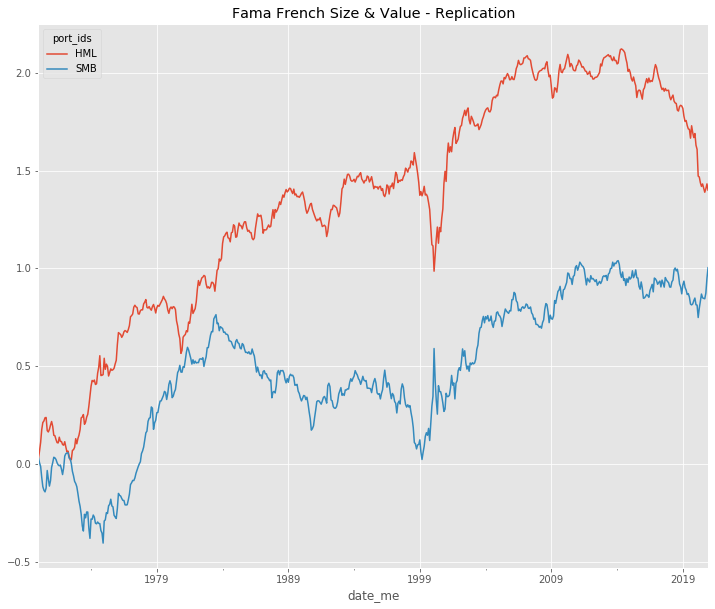

In [51]:
ff_factors.loc['1970/01':,['HML','SMB']].cumsum().plot()
plt.title('Fama French Size & Value - Replication')